## Final Project Submission


* Student name: Robert Fustero 
* Student pace: part time
* Scheduled project review 12/13/19
* Instructor name: Jeff Herman

In [3]:
import numpy as np
import pandas as pd
import soundfile
import IPython
import librosa
import librosa.display
from python_speech_features import mfcc, logfbank
from scipy.io import wavfile
import os
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

# Introduction

The goal of this project was to create a drum sound classifier for music producers using a convolutional nueral network.
This is very useful because often times drum sounds are hard to find purely based on the file name. 
This gives people a way to search for the sound itself using the audio rather than the file name.

## Process

First I needed to build a dataframe with all the file names and the drum label as a categorical feature

In [4]:
def file_lister(name):
    '''lists all the files in a folder'''
    listy = []
    path = name
    try:
        files = os.listdir(path)
        for file in files:
            listy.append(file)
    except:
        None
    return listy

columns = ['fname', 'category']
df = pd.DataFrame(columns=columns)
categories = file_lister('Main Audio Folder')
for x in categories:
    for root, dirs, files in os.walk('Main Audio Folder/'+x):
        for file in files:
            if file.endswith('.wav'):
                df = df.append({'fname' : file , 'category' : x} , ignore_index=True)
                data, samplerate = soundfile.read('Main Audio Folder/'+x+'/'+file)
                soundfile.write('DrumSamples/'+file, data, samplerate, subtype='PCM_16')

df.to_csv('Drum Categories.csv')
df.head() 

,fname,category
0,S_S95_01_BdH1_-_ (17).wav,Kick
1,KICK - BLOCKA.wav,Kick
2,Do What U Do Kick 1.wav,Kick
3,CANTHEM Kick 2.wav,Kick
4,KICK - TEEN SPIRT.wav,Kick


### Amount of data in each class

We do have class imbalance this will be dealt with later through upsampling

In [5]:
for x in np.unique(df.category):
    print(x+': '+str(len(df[df.category==x])))

808: 283
Clap: 385
Closed Hat: 414
Kick: 885
Open Hat: 230
Snare: 866
Tom: 296
Vox: 1120


# Mel-frequency cepstral coefficients (MFCCs)
The MFCCs takes the frequency copenents (spectrogram) and put it into the mel-space which approximates how humans hear better than linear spaced frequencies.

To get the MFFC of a signal you must
1. Compute the Fast Fourier Transform of the signal
2. Apply a Mel-space filter bank to the spectrum
3. Compute a discrete cosine transform of the log filter-bank energies

## Important thing to keep in mind

CNNs deal with static information.  Audio samples come in different sized arrays.  Inorder to make the CNN understand the audio information - the MFFCs were averaged over time so every sample evaluted by the algorithim has a length of 128.

In [6]:

def extract_features(file_name):
    '''takes the averaged mfccs of the wave file'''
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        audiot = librosa.effects.trim(audio)[0]
        mfccs = librosa.feature.mfcc(y=audiot, sr=sample_rate, n_mfcc=256)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccsscaled

In [8]:
def mfccs_plot(file_name, title='Mel-frequency spectrogram'):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        audiot = librosa.effects.trim(audio)[0]
        S = librosa.feature.melspectrogram(y=audiot, sr=sample_rate)
        plt.figure(figsize=(10, 4))
        S_dB = librosa.power_to_db(S, ref=np.max)
        librosa.display.specshow(S_dB, x_axis='time',
                                 y_axis='mel', 
                                 fmax=8000)
        plt.colorbar(format='%+2.0f dB')
        plt.title(title)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return None

# MFCC PLOTS

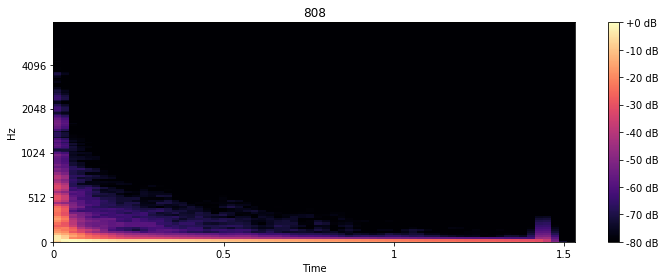

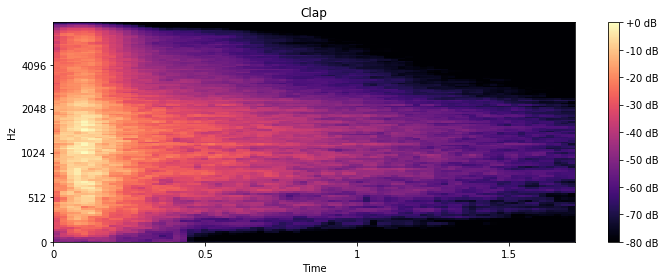

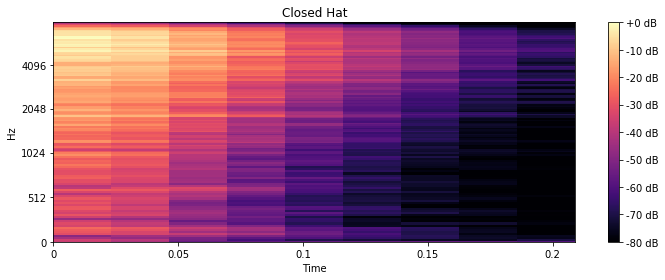

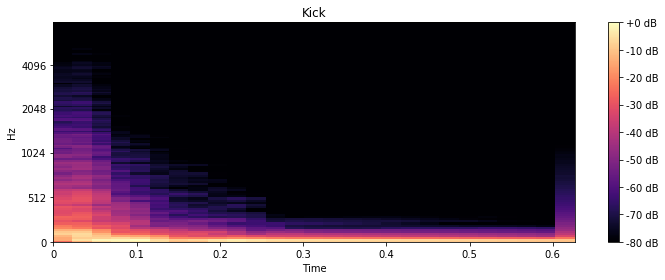

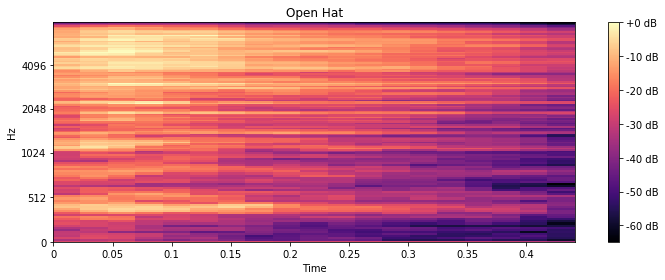

In [11]:
from random import sample
for x in np.unique(df.category)[0:5]:
    files = df[df.category==x].fname
    file = sample(list(files),1)[0]
    mfccs_plot('DrumSamples/'+file,title=x)

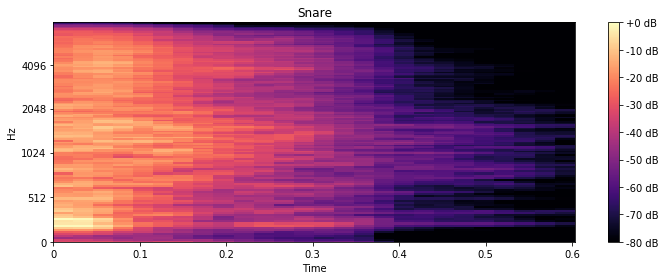

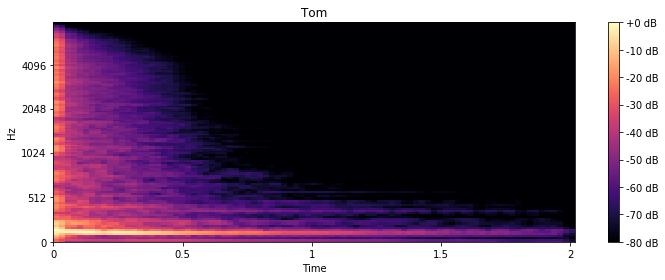

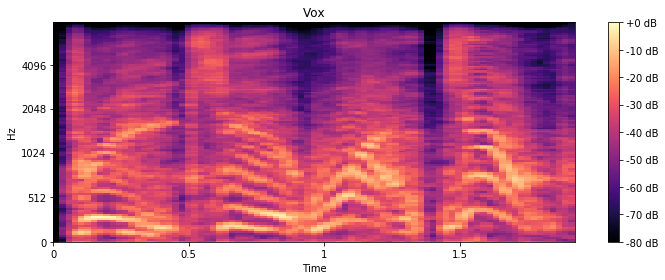

In [12]:
for x in np.unique(df.category)[5:]:
    files = df[df.category==x].fname
    file = sample(list(files),1)[0]
    mfccs_plot('DrumSamples/'+file,title=x)

## Extracting features for all the data

In [14]:
fulldatasetpath = 'DrumSamples/'

X = []

features = []



                    
                    
for files in os.walk('DrumSamples/'):
    for file in files:
        for x in file:
            if x.endswith('.wav'):
                class_label = list(df.loc[df['fname'] == x].category)[0]
                data = extract_features('DrumSamples/'+x)
                X.append(data)
                features.append([data, class_label])

featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
X = np.array(X)

print('Finished feature extraction from ', len(featuresdf), ' files')

Finished feature extraction from  4478  files


# Up-Sampling to deal with Class Imbalance

Up-sampling randomly samples other classes until it matches the amount other the class with the most samples.  <br>
We need to do this for class imbalance because every class has an equal chance being called.

In [15]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss

# Convert features and corresponding classification labels into numpy arrays
#X = np.array(featuresdf.feature)
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
sm = SMOTETomek(random_state = 3)
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

#X_res, y_res = sm.fit_sample(X,yy)

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)


In [16]:
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

In [17]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

In [18]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(8,(3,3), activation='relu', strides=(1,1),
                    padding = 'same', input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(Conv2D(16,(3,3), activation='relu', strides=(1,1),
                    padding = 'same', input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(Conv2D(32,(3,3), activation='relu', strides=(1,1),
                    padding = 'same', input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(Conv2D(64,(3,3), activation='relu', strides=(1,1),
                    padding = 'same', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Conv2D(128,(3,3), activation='relu', strides=(1,1),
                    padding = 'same', input_shape=input_shape))


    model.add(MaxPool2D((1,1),strides=2))



    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dense(96, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(8, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['acc'])
    return model

In [19]:
from keras.callbacks import ModelCheckpoint 

## Used ModelCheckpoint to save best model

I used a model checkpoint so it would save the best model no matter how many times I trained it. The input shape goes as follows, (batch_size, height, width, depth).  The batchsize is given the the first index of the .shape feature.  128 is the length of the array - again this represnts the averaged MFFCs over time.  The width is 1 and the depth is 1 because it's a 1 demensional array measuring the average frequency amplitudes.

In [20]:

checkpointer = ModelCheckpoint(filepath='weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
x_train = x_train.reshape(x_train.shape[0], 128, 1, 1)
x_test = x_test.reshape(x_test.shape[0], 128, 1, 1)
input_shape = (128, 1, 1)
model = get_conv_model()
#model.fit(x_train, y_train, batch_size=677, epochs=100, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)

W1211 12:48:00.789160 4527105472 deprecation_wrapper.py:119] From /Users/robertfustero/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1211 12:48:00.843094 4527105472 deprecation_wrapper.py:119] From /Users/robertfustero/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1211 12:48:00.860761 4527105472 deprecation_wrapper.py:119] From /Users/robertfustero/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1211 12:48:00.893544 4527105472 deprecation_wrapper.py:119] From /Users/robertfustero/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 1, 8)         80        
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 1, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 1, 16)        1168      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 1, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 1, 32)        4640      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128, 1, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 1, 64)        18496     
__________

In [21]:
# Loads the weights
model.load_weights('weights.best.basic_cnn.hdf5')

# Re-evaluate the model
loss,acc = model.evaluate(x_test,  y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

Restored model, accuracy: 97.54%


In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report


In [51]:
def display_acc_and_f1_score(true, preds, model_name):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds,average='micro')
    print("Model: {}".format(model_name))
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))

In [27]:
cnn_train_preds = model.predict(x_train)
cnn_test_preds = model.predict(x_test)

In [40]:
y_truetrain = []
y_predtrain = []
for x in range(len(x_train)):
    y_truetrain.append(np.argmax(y_train[x]))
    y_predtrain.append(np.argmax(cnn_train_preds[x]))

In [41]:
y_truetest = []
y_predtest = []
for x in range(len(x_test)):
    y_truetest.append(np.argmax(y_test[x]))
    y_predtest.append(np.argmax(cnn_test_preds[x]))

In [63]:
print("Training Metrics")
display_acc_and_f1_score(y_truetrain, y_predtrain, model_name='CNN')
print("")
print("Testing Metrics")
display_acc_and_f1_score(y_truetest, y_predtest, model_name='CNN')
print("")



Training Metrics
Model: CNN
Accuracy: 0.9729201563372417
F1-Score: 0.9729201563372417

Testing Metrics
Model: CNN
Accuracy: 0.9754464285714286
F1-Score: 0.9754464285714286



In [65]:
print(list(np.unique(df.category)))
print("Classification Report:")
print("")
print(classification_report(y_predtest,y_truetest))

['808', 'Clap', 'Closed Hat', 'Kick', 'Open Hat', 'Snare', 'Tom', 'Vox']
Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        61
           1       0.95      0.90      0.92        80
           2       1.00      0.99      0.99        78
           3       0.98      0.99      0.99       166
           4       1.00      1.00      1.00        47
           5       0.94      0.98      0.96       193
           6       1.00      0.98      0.99        61
           7       0.99      0.98      0.98       210

    accuracy                           0.98       896
   macro avg       0.98      0.97      0.98       896
weighted avg       0.98      0.98      0.98       896



# Conclusion

An overall weighted average of 98% is pretty good.  CNNs are a good solution for classifying audio of shorter lengths - because the averaged MFFCs the sample will leave are going to be more unique.  With longer time periods, theres more room for a CNN to make mistakes because the frequencies are all being averaged.  The snare and clap had lower precision their frequency ranges span simiarly to other sounds - where as an 808 has a very specific frequency range.<br>

For a future project it would be cool to build a classifier with a GRU or LSTM so it can handle the time series information better.

# Website

I made a website with Flask!  Upload your own drum .wav samples here and see if my ML model can get it right! <br>

https://intense-oasis-99800.herokuapp.com/